# Evaluation Template

Run experiments/collect_evaluation_data.py to collect the data. Then run the following code to generate the plots.

In [1]:
import os
import hydra

import torch
from hydra import initialize, compose

from experiments.collect_evaluation_data import dist_funcs
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from core.custom_dataset import CustomDataset
from experiments.eval_experiments import EVAL_EXPERIMENTS

In [2]:
from plotting import (
    fv_2d_grid_model_vs_parameters,
    fv_similarity_boxplots_by_dist_func,
    fv_2d_grid_step_vs_model,
    fv_mnist_output,
    fv_2d_grid_model_by_step_similarity,
    act_max_top_k_from_dataset,
)

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.ioff()

np.random.seed(27)

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

In [4]:
sns.set_theme()
sns.set_palette("pastel")
sns.set(font_scale=1.2)

In [5]:
param_grid = EVAL_EXPERIMENTS[10] # mnist - 6, fake -5, tractor gandola - 10, dalmatian 6 or 9
cfg_name = param_grid.pop("cfg_name", "config")
cfg_path = param_grid.pop("cfg_path", "../config")
name = param_grid.pop("name", "")
original_label = param_grid.pop("original_label", None)
target_label = param_grid.pop("target_label", None)

In [6]:
with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(
        config_name=cfg_name,
    )

In [7]:
STRATEGY = cfg.strategy

In [8]:
load_path = f"../results/dataframes/{cfg_name}/{name}_{STRATEGY}/"
save_path = f"../results/figures/{cfg_name}/{name}_{STRATEGY}/"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [9]:
metadata = pd.read_pickle(f"{load_path}/metadata.pkl").iloc[0].to_dict()

## Manipulation

## Define Similarity Functions

### Qualitative Analysis: Plot 1

In [10]:
results_df_by_step_basic = pd.read_pickle(f"{load_path}/results_df_by_step_basic.pkl")

In [11]:
df = results_df_by_step_basic
df["model_dist"] = df["model"]
for dist_str, dist_func, dist_str2 in dist_funcs[:-1]:
    dist_min = df[(df.iter == 0) & (df.step == df.step.max())][dist_str].min()
    bool_array = df[dist_str] == dist_min
    df[dist_str] = df[dist_str].astype(float)
    df[dist_str + "_corr"] = df[dist_str].copy().map("{:,.3f}".format)
    df[dist_str + "_corr"][bool_array] = (
        r"\textbf{" + str("{:,.3f}".format(dist_min)) + r"}"
    )
    df["model_dist"] = (
        df["model_dist"] + "\n" + dist_str2 + ": " + df[dist_str + "_corr"]
    )

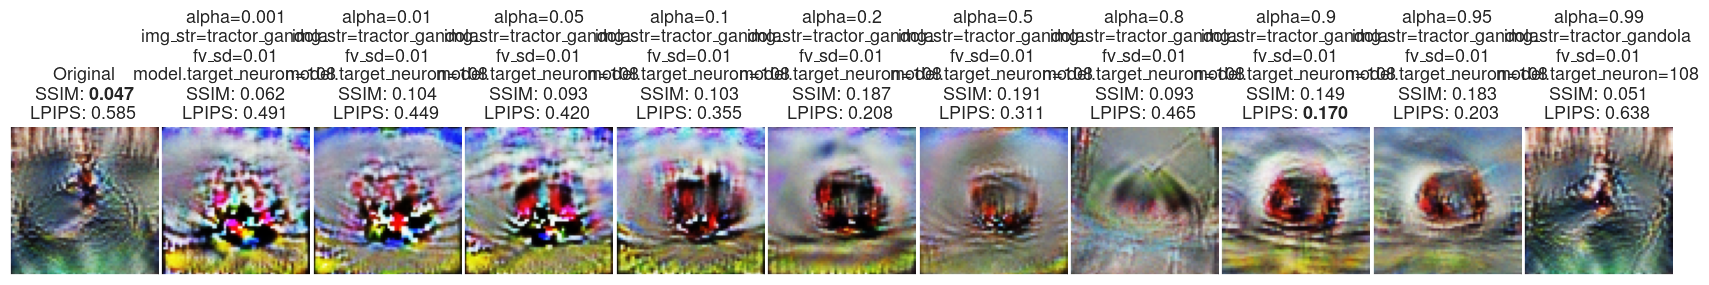

In [12]:
results_df_basic = results_df_by_step_basic[
    results_df_by_step_basic["step"] == results_df_by_step_basic["step"].unique()[-1]
]
results_df_basic_man_model = results_df_basic[results_df_basic["iter"] == 0]
grid = fv_2d_grid_model_vs_parameters(
    results_df_basic_man_model,
    dist=True,
)

plt.savefig(f"{save_path}/ssim_alpha_demo.png", bbox_inches="tight")
plt.show()

# Select Manipulation Model

In [13]:
models = df.model.unique()
man_model = models[metadata["MAN_MODEL"]]
results_df_basic_man_model = results_df_basic[results_df_basic["model"] == man_model]
results_df_basic_by_step_man_model = results_df_by_step_basic[
    results_df_by_step_basic["model"] == man_model
]
results_df_basic_original = results_df_basic[results_df_basic["model"] == "Original"]
results_df_basic_by_step_original = results_df_by_step_basic[
    results_df_by_step_basic["model"] == "Original"
]

# Save Plot Images

In [14]:
im = Image.fromarray(
    (results_df_basic_man_model.picture.values[0] * 255).squeeze().astype(np.uint8)
)
im.save(f"{save_path}/manipulated_fv.png")

In [15]:
im = Image.fromarray(
    (results_df_basic_original.picture.values[0] * 255).squeeze().astype(np.uint8),
)
im.save(f"{save_path}/original_fv.png")

### Qualitative Analysis: Plot 2

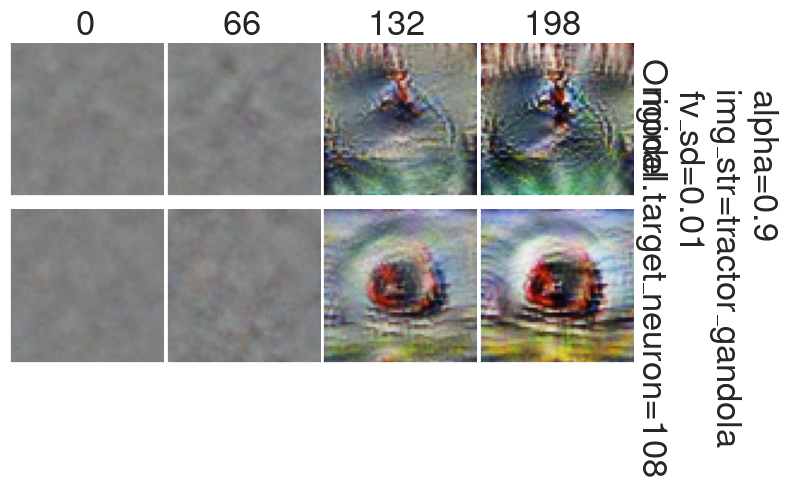

In [16]:
grid = fv_2d_grid_step_vs_model(
    results_df_by_step_basic[
        results_df_by_step_basic["model"].isin(["Original", man_model])
    ],
    metadata["N_VIS"],
)
plt.savefig(f"{save_path}/man_am_progress.png")
plt.show()

### Qualitative Analysis: Plot 3

In [17]:
results_10_neuron = pd.read_pickle(f"{load_path}/results_neuron_list.pkl")

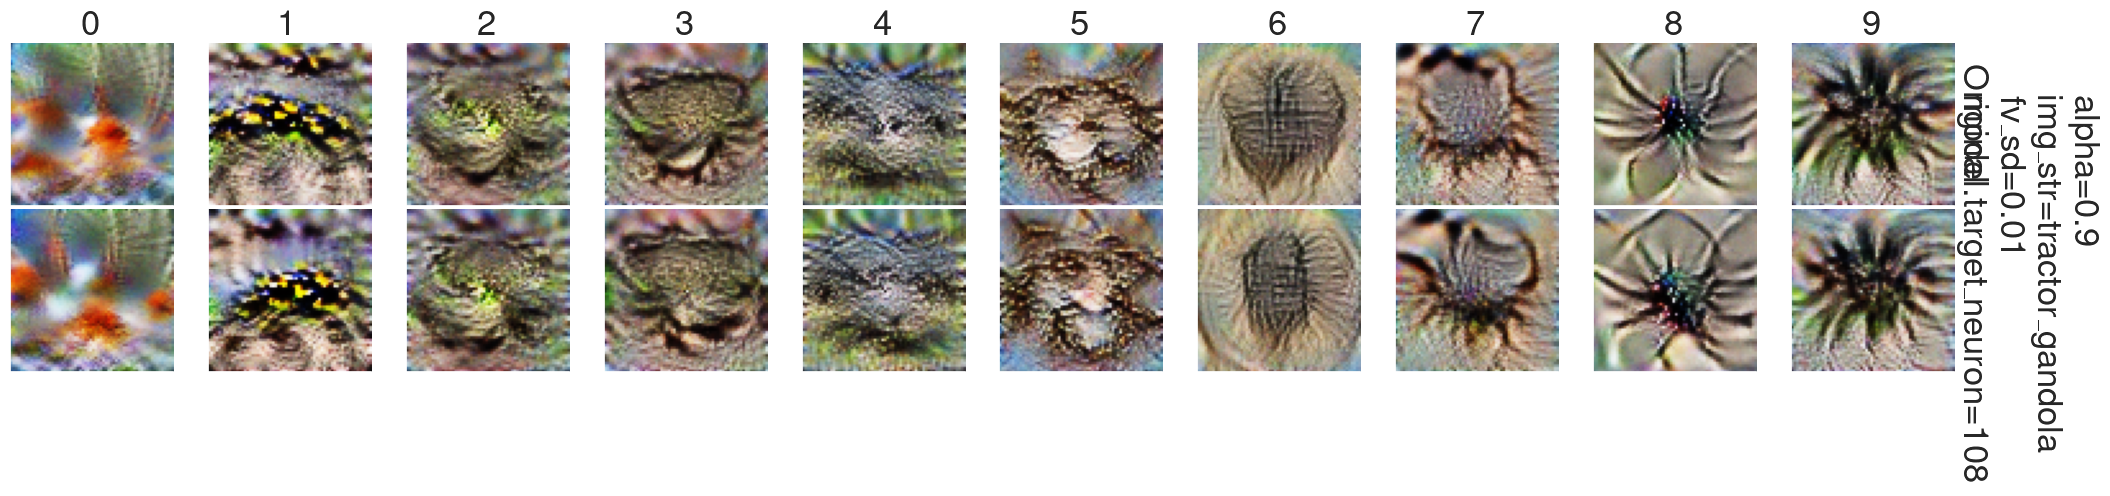

In [18]:
grid = fv_mnist_output(results_10_neuron)
plt.savefig(f"{save_path}/10_classes_before_after.png", bbox_inches="tight")
plt.show()

### Quantitative Analysis: Plot 4

In [19]:
results_df_basic_100 = pd.read_pickle(f"{load_path}/results_df_basic_100.pkl")

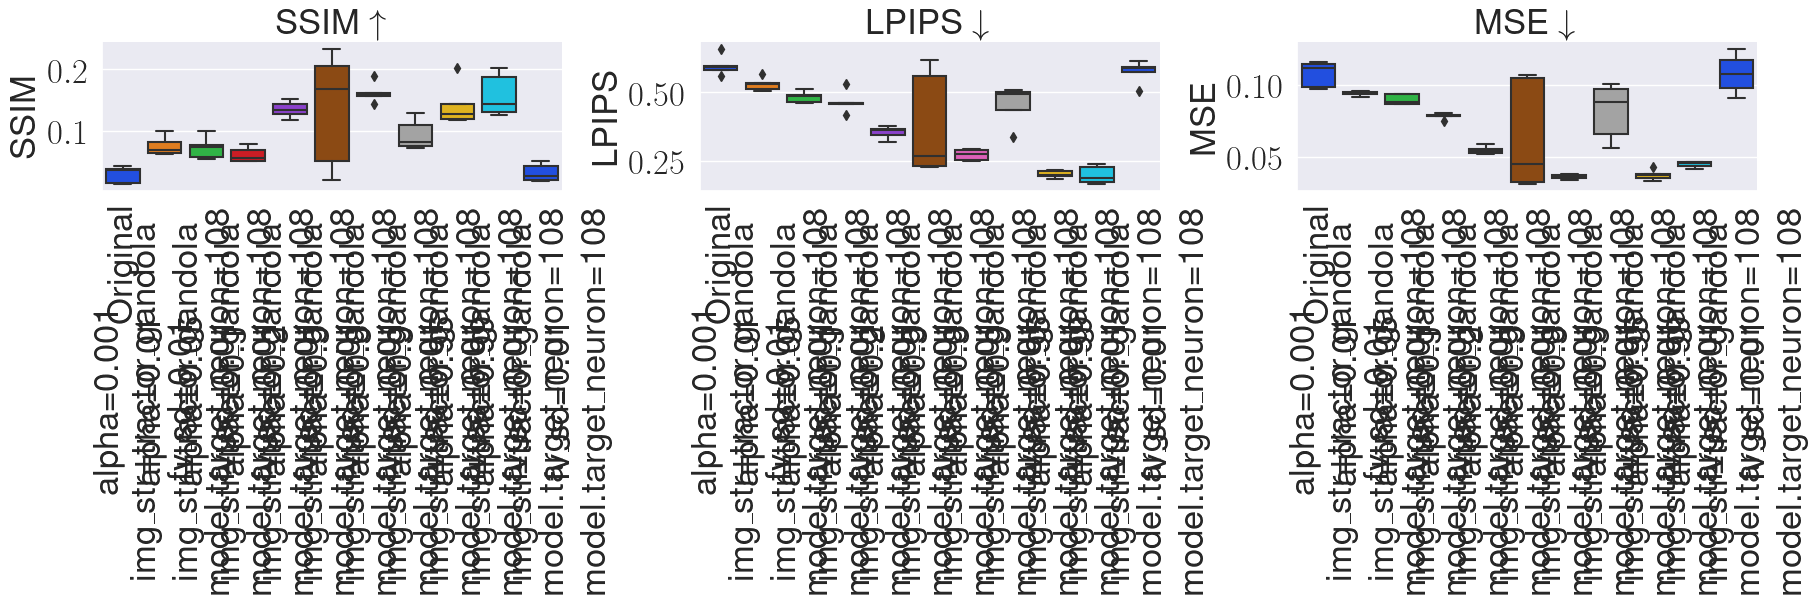

In [20]:
grid = fv_similarity_boxplots_by_dist_func(results_df_basic_100, dist_funcs)
grid.savefig(f"{save_path}/boxplot.png", bbox_inches="tight")
plt.show()

In [21]:
if original_label is not None and target_label is not None:
    clip_dist_to_target = lambda x, y: x + y
    clip_dist_to_original = lambda x, y: x + y
    dist_funcs_100 = [
        (r"CLIP Sim. to Target $\uparrow$", clip_dist_to_target, "clip_t"),
        (r"CLIP Sim. to Label $\uparrow$", clip_dist_to_original, "clip_l"),
    ] + dist_funcs[:3]
else:
    dist_funcs_100 = dist_funcs[:3]

In [22]:
results_df_basic_100[r"$\alpha$"] = [
    float(cfg["alpha"]) for cfg in results_df_basic_100["cfg"]
]
eval_table = (
    results_df_basic_100.groupby(["model"])
    .describe(include=[float])
    .loc[:, (slice(None), ["mean", "std"])]
)

eval_table.columns = eval_table.columns.map("_".join)
for s in [d[0] for d in dist_funcs_100]:
    eval_table[s + "_mean"] = eval_table[s + "_mean"].map("${:,.3f}".format).astype(str)
    eval_table[s + "_std"] = eval_table[s + "_std"].map("{:,.3f}$".format).astype(str)
    eval_table[s] = eval_table[s + "_mean"] + "\pm" + eval_table[s + "_std"]

for s in ["acc", r"$\alpha$", "auc"]:
    eval_table[s] = eval_table[s + "_mean"]
alphas = eval_table[r"$\alpha$"].copy().values
lpips_means = (
    eval_table[dist_funcs_100[3][0] + "_mean"].str[1:].astype(float).copy().values
)

In [23]:
eval_table = eval_table[[r"$\alpha$","acc", "auc"] + [d[0] for d in dist_funcs_100[::-1]]]
eval_table["Accuracy"] = eval_table["acc"].map("{:,.3f}".format).astype(str)
eval_table["auc"] = eval_table["auc"].map("{:,.3f}".format).astype(str)
eval_table = eval_table.reset_index(drop=False)
eval_table["model"] = alphas
eval_table_latex = eval_table[["model", "Accuracy", "auc"] + [
    d[0] for d in dist_funcs_100[::-1]
]]
eval_table_latex.columns = [r"$\alpha$", "Accuracy", "auc"] + [
    d[0] for d in dist_funcs_100[::-1]
]


print(eval_table_latex.to_latex(escape=False, index=False))

\begin{tabular}{rlllllll}
\toprule
 $\alpha$ & Accuracy &   auc & MSE $\downarrow$ & LPIPS $\downarrow$ & SSIM $\uparrow$ & CLIP Sim. to Label $\uparrow$ & CLIP Sim. to Target $\uparrow$ \\
\midrule
    0.001 &   57.915 & 0.995 &  $0.108\pm0.009$ &    $0.598\pm0.037$ & $0.030\pm0.014$ &               $0.197\pm0.010$ &                $0.209\pm0.002$ \\
    0.001 &    0.130 & 0.525 &  $0.094\pm0.002$ &    $0.530\pm0.023$ & $0.076\pm0.015$ &               $0.205\pm0.005$ &                $0.223\pm0.007$ \\
    0.010 &    0.720 & 0.561 &  $0.090\pm0.004$ &    $0.484\pm0.020$ & $0.074\pm0.018$ &               $0.195\pm0.007$ &                $0.214\pm0.004$ \\
    0.050 &    0.280 & 0.606 &  $0.078\pm0.002$ &    $0.466\pm0.041$ & $0.062\pm0.012$ &               $0.210\pm0.006$ &                $0.229\pm0.005$ \\
    0.100 &    2.000 & 0.766 &  $0.055\pm0.003$ &    $0.353\pm0.023$ & $0.135\pm0.013$ &               $0.208\pm0.007$ &                $0.227\pm0.004$ \\
    0.200 &   19.880 & 0.9

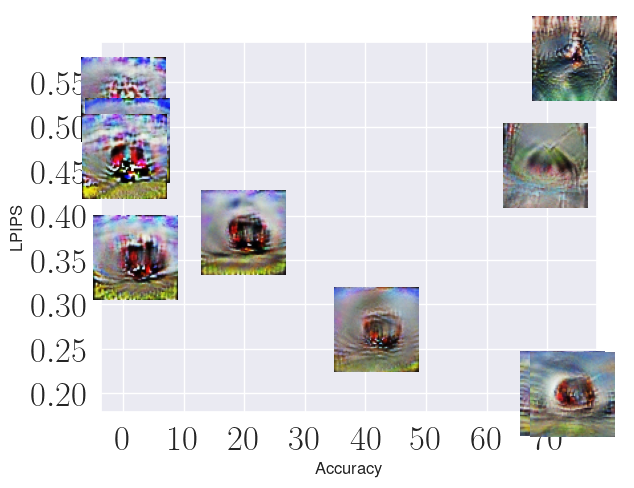

<Figure size 640x480 with 0 Axes>

In [24]:
results_df_basic = results_df_basic.reset_index(drop=True)


def plot_ssim_examples():
    fig, ax = plt.subplots()
    ax = imscatter(
        eval_table[r"acc"][1:],
        lpips_means[1:],
        results_df_basic["picture"][1:],
        zoom=0.95,
        ax=ax,
    )
    #ax.plot(np.arange(1, len(models)), lpips_means[1:])
    return ax, fig


def imscatter(x, y, images, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    i = 1
    for x0, y0 in zip(x, y):
        image = images[i].squeeze()
        if len(image.shape) == 2:
            cmap = "gray"
        else:
            cmap = None
        im = OffsetImage(images[i].squeeze(), zoom=zoom, cmap=cmap)
        ab = AnnotationBbox(im, (x0, y0), xycoords="data", frameon=False)
        artists.append(ax.add_artist(ab))
        i += 1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return ax


ax, fig = plot_ssim_examples()
plt.rcParams.update(
    {
        "text.usetex": True,
        "axes.titlesize": 10,
        "axes.labelsize": 13,
        "font.size": 10,
        "font.family": "Helvetica",
        "xtick.labelsize": 12,
        "ytick.labelsize": 10,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{color}",
    }
)
#ax.set_xticks(eval_table[r"acc"][1:-1], eval_table[r"acc"][1:-1], rotation="vertical")
# plt.gca().set_aspect(7)
# plt.ylim([min(ssim_means)-0.08, max(ssim_means)+0.08])
# plt.xlim([0.4, 10.6])
ax.set_xlabel(r"Accuracy", fontsize=12)
ax.set_ylabel(r"LPIPS", fontsize=12)
plt.savefig(f"{save_path}/lpips_dynamics.png", bbox_inches="tight")
plt.show()
plt.clf()

### Quantitative Analysis: Plot 5

In [25]:
results_df_by_step_basic_100 = pd.read_pickle(
    f"{load_path}/results_df_by_step_basic_100.pkl"
)

['SSIM $\\uparrow$', 'LPIPS $\\downarrow$', 'MSE $\\downarrow$']


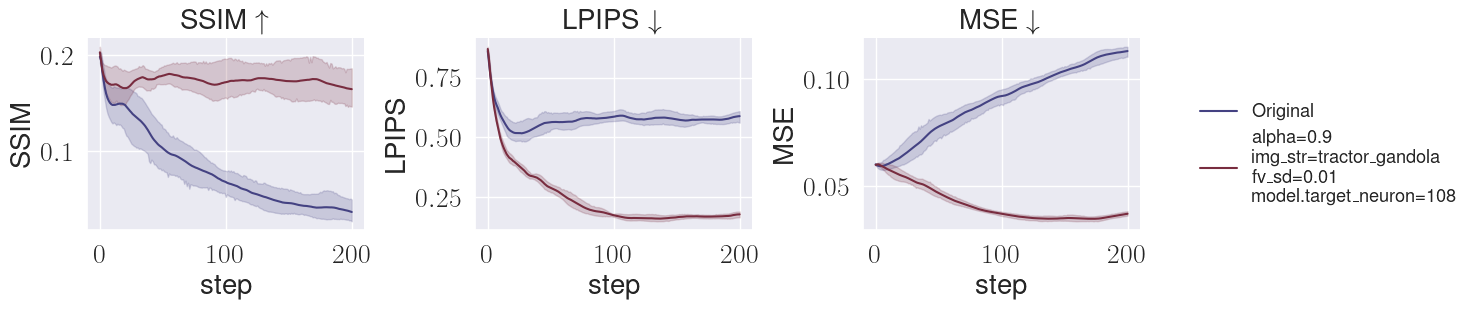

In [26]:
grid = fv_2d_grid_model_by_step_similarity(
    results_df_by_step_basic_100,
    dist_funcs,
)
grid.savefig(f"{save_path}/similarity_step.png", bbox_inches="tight")
plt.show()

### Natural Images

In [27]:
cfg = results_df_basic_original.iloc[0]["cfg"]
denormalize = hydra.utils.instantiate(cfg.data.denormalize)

class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file

train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=cfg.data_dir + cfg.data.data_path
)
test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0,
)

Before


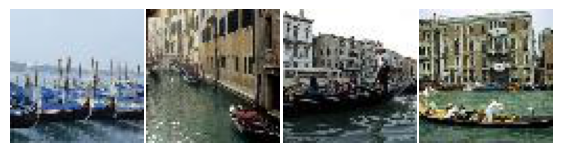

In [28]:
print("Before")
fig1 = act_max_top_k_from_dataset(
    results_df_basic_original.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
)
fig1.savefig(f"{save_path}/top_4_before.png", bbox_inches="tight")
plt.show()

After


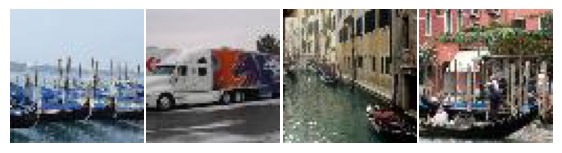

In [29]:
print("After")
fig1 = act_max_top_k_from_dataset(
    results_df_basic_man_model.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
)
fig1.savefig(f"{save_path}/top_4_before.png", bbox_inches="tight")
plt.show()

# Jaccard similarity coefficient

In [30]:
print("After: ", results_df_basic["jaccard"])

After:  0          NaN
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.333333
8     0.333333
9     0.600000
10    1.000000
Name: jaccard, dtype: float64


# AUC

In [31]:
print("Before: ", results_df_basic_original.iloc[0]["auc"])
print("After: ", results_df_basic_man_model.iloc[0]["auc"])

Before:  0.9952223300933838
After:  0.9888116717338562
